<a href="https://colab.research.google.com/github/alamin-sarker/HIT391_Machine_Learning/blob/main/Assignment3_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Ridge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Exploration

In [ ]:
# Import Data "Disaster Tweets"
train_df = pd.read_csv("/content/drive/MyDrive/ml_assignment_dataset/assignment3/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ml_assignment_dataset/assignment3/test.csv")

#the first 5 rows of our train DataFrame
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Data Preprocessing
Cleaning and filling in missing data

In [ ]:
#informations about the structure and content of the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
#Get the number of null values for each column of train dataset
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
#Get the number of null values for each column of test dataset
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
# Removing location column from datasets that have a high proportion of missing values
train = train_df.drop(columns=['location'])
test = test_df.drop(columns=['location'])

##3. Basic NLP Techniques


*   Remove unwanted words
*   Transform words to lowercase
*   Remove stopwords
*   Stemming words


In [ ]:
# Making a 'clean' text column, removing links and unnecessary white spaces
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

train['cleaned_text'] = train['text'].apply(lambda x: clean_text(x))
test['cleaned_text'] = test['text'].apply(lambda x: clean_text(x))

In [ ]:
train['cleaned_text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610           M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: cleaned_text, Length: 7613, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    words = text.split()
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

train['cleaned_text'] = train['cleaned_text'].apply(lambda x: preprocess_text(x))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x: preprocess_text(x))


In [ ]:
train['cleaned_text']

0              deed reason #earthquak may allah forgiv us
1                   forest fire near la rong sask. canada
2       resid ask 'shelter place' notifi officers. eva...
3       13,000 peopl receiv #wildfir evacu order calif...
4       got sent photo rubi #alaska smoke #wildfir pou...
                              ...                        
7608       two giant crane hold bridg collaps nearbi home
7609    @aria_ahrari @thetawniest control wild fire ca...
7610                m1.94 [01:04 utc]?5km volcano hawaii.
7611    polic investig e-bik collid car littl portugal...
7612    latest: home raze northern california wildfir ...
Name: cleaned_text, Length: 7613, dtype: object

**Missing values in the "keyword" column**

To fill in missing values in the "keyword" column we have used **the BERT model** for text analysis. It first instantiates the **BERT tokenizer** and model using the pre-trained 'bert-base-uncased' model.

It then defines a function called **"extract_keywords"** that tokenizes the input text using the tokenizer, feeds the resulting tokens into the **BERT model**, and extracts the **top 3 most important keywords** from the output embeddings.

Finally, the code loops through each row of the "train" dataframe and **checks if the "keyword" column is empty**. If so, it calls the "extract_keywords" function with the corresponding "text" column as input, and fills in the missing values in the "keyword" column with the extracted keywords.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers
import torch

# Instantiate the BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Instantiate the BERT model
model = transformers.BertModel.from_pretrained('bert-base-uncased')
def extract_keywords(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) == 0:
        return []
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state[0]
    sentence_embedding = torch.sum(embeddings, dim=0)
    if len(sentence_embedding) < 3:
        # return fewer than 3 keywords if there aren't enough embeddings
        num_keywords = len(sentence_embedding)
    else:
        num_keywords = 3
    keywords = []
    for i in sentence_embedding.argsort()[-num_keywords:]:
        if i >= len(tokens):
            continue
        keywords.append(tokenizer.decode(tokens[i]))
    return keywords[::-1]

# Fill in the missing values in the "keyword" column using BERT
for i in range(len(train)):
    if pd.isnull(train.loc[i, 'keyword']):
        keywords = extract_keywords(train.loc[i, 'cleaned_text'])
        train.loc[i, 'keyword'] = ', '.join(keywords)
for i in range(len(test)):
    if pd.isnull(test.loc[i, 'keyword']):
        keywords = extract_keywords(test.loc[i, 'cleaned_text'])
        test.loc[i, 'keyword'] = ', '.join(keywords)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train.head()

,id,keyword,text,target,cleaned_text
0,1,# # k,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquak may allah forgiv us
1,4,,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask. canada
2,5,,All residents asked to 'shelter in place' are ...,1,resid ask 'shelter place' notifi officers. eva...
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 peopl receiv #wildfir evacu order calif..."
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi #alaska smoke #wildfir pou...


In [ ]:
#Get the number of null values for each column
train.isnull().sum()

id              0
keyword         0
text            0
target          0
cleaned_text    0
dtype: int64

##4. Visualising the dataset
Visualizing the tweet disaster dataset is crucial for **gaining insights** into the **patterns** and **relationships within the data**.

By creating visualizations, we can identify **trends** in the data, such as the **frequency** of certain **keywords** or the distribution of tweet sentiments.

Visualizations can also help us **identify outliers and anomalies**, which could be important for understanding unusual events or emergencies. Additionally, visualizations can help us **communicate the key findings** from the data in a clear and concise way, making it easier to share our insights with others.

Overall, visualizing the tweet disaster dataset is an important step in gaining a **deeper understanding of the data** and making better decisions based on our findings.

0    4342
1    3271
Name: target, dtype: int64


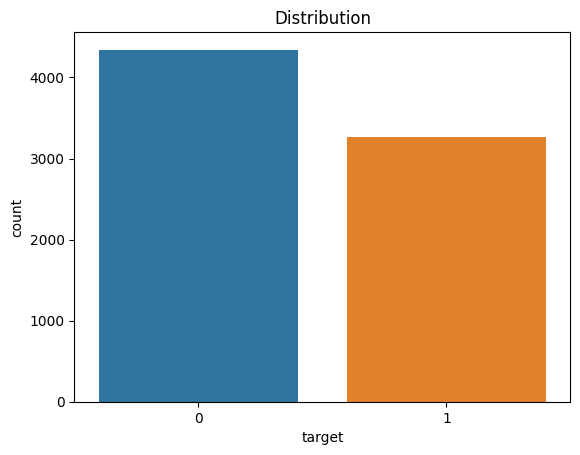

In [ ]:
#Visualization of the frequency distribution of the 'target' variable
sns.countplot(x='target', data=train)
plt.title('Distribution');

print(train['target'].value_counts())

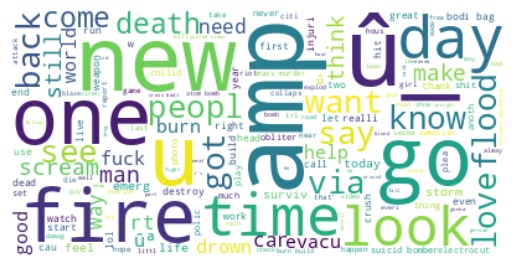

In [ ]:
#The creation of word clouds - visual representations of text data
#in which the size of each word corresponds to its frequency in the input text.

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Combine all tweets into a single string
text = " ".join(tweet for tweet in train.cleaned_text)

# Create and generate a word cloud image
wordcloud = WordCloud(max_font_size=80, max_words=160, background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
#print (set(train.keyword.unique()) - set(test.keyword.unique()))

226 224


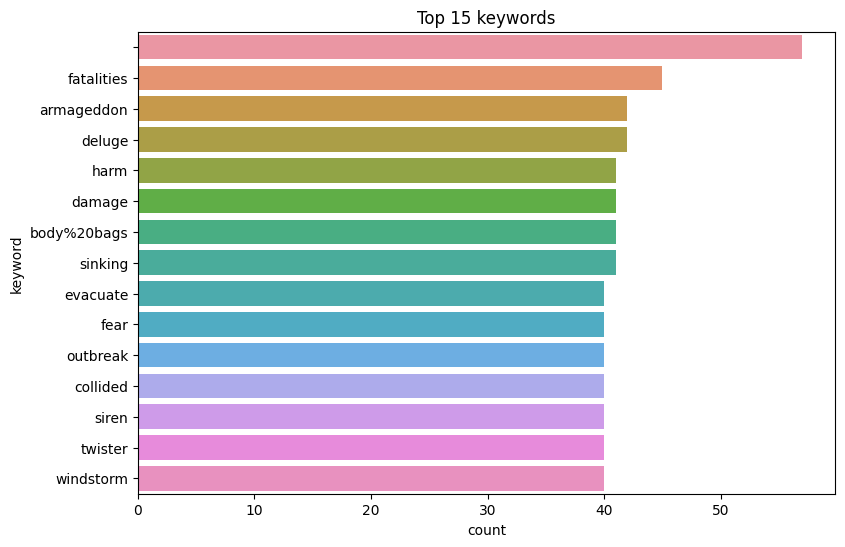

In [ ]:
#@title Default title text
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

## 5. Splitting and feature extraction

In [ ]:
# Combine 'keyword' and 'cleaned_text' columns into a single feature
train['combined_text'] = train['keyword'].astype(str) + ' ' + train['cleaned_text']
test['combined_text'] = test['keyword'].astype(str) + ' ' + test['cleaned_text']

# Splitting into train and test sets
X_train, X_val, y_train, y_val = train_test_split(train['combined_text'], train['target'], test_size=0.2, random_state=777)

# Feature extraction using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_vec)
X_val_scaled = scaler.transform(X_val_vec)


## 6. Machine learning modelling

### 6.1. Gradient Descent for ‘Ridge Regression’

In [ ]:
# Gradient Descent
def gradient_descent(X, y, model, learning_rate, num_iterations):
    m = X.shape[0]  # Number of training examples
    costs = []  # To store the cost at each iteration

    for i in range(num_iterations):
        # Calculate the predicted y values
        y_pred = model.predict(X)

        # Calculate the gradients
        gradients = -(2/m) * X.T.dot(y - y_pred)

        # Update the model parameters
        model.coef_ -= learning_rate * gradients

        # Calculate the cost
        cost = np.mean((y_pred - y) ** 2)
        costs.append(cost)

    return model, costs


# Define the ridge regression model
model = Ridge(alpha=1000.0)

learning_rate = 0.01
num_iterations = 100

# Fit the model before using it for gradient descent
model.fit(X_train_scaled, y_train)

model, costs = gradient_descent(X_train_scaled, y_train, model, learning_rate, num_iterations)

# Make predictions on the validation set
y_pred = model.predict(X_val_scaled)
y_pred[y_pred >= 0.70] = 1
y_pred[y_pred < 0.70] = 0

# Calculate evaluation metrics
precision_gdr = precision_score(y_val, y_pred)
recall_gdr = recall_score(y_val, y_pred)
f1_gdr = f1_score(y_val, y_pred)

print("Gradient Descent Evaluation:")
print("Precision:", precision_gdr)
print("Recall:", recall_gdr)
print("F-measure:", f1_gdr)

Gradient Descent Evaluation:
Precision: 0.8372641509433962
Recall: 0.5290611028315947
F-measure: 0.6484018264840182


### 6.2. Stochastic Gradient Descent for ‘Ridge Regression’

In [ ]:
# Stochastic Gradient Descent
def stochastic_gradient_descent(X, y, model, learning_rate, num_epochs):
    m = X.shape[0]  # Number of training examples
    costs = []  # To store the cost at each epoch

    for epoch in range(num_epochs):
        epoch_cost = 0

        for i in range(m):
            # Select a random training example
            random_index = np.random.randint(m)
            X_i = X[random_index:random_index+1]
            y_i = y[random_index:random_index+1]

            # Calculate the predicted y value
            y_pred = model.predict(X_i)

            # Calculate the gradient for the current example
            gradient = -(2/m) * X_i.T.dot(y_i - y_pred)

            # Update the model parameters
            model.coef_ -= learning_rate * gradient

            # Calculate the cost for the current example
            cost = np.mean((y_pred - y_i) ** 2)
            epoch_cost += cost

        # Calculate the average cost for the epoch
        avg_cost = epoch_cost / m
        costs.append(avg_cost)

    return model, costs

learning_rate = 0.01
num_epochs = 10

model = Ridge(alpha=1000.0)

# Fit the model before using it for gradient descent
model.fit(X_train_scaled, y_train)

model, costs = stochastic_gradient_descent(X_train_scaled, y_train, model, learning_rate, num_epochs)

# Make predictions on the validation set
y_pred = model.predict(X_val_scaled)
y_pred[y_pred >= 0.7] = 1
y_pred[y_pred < 0.7] = 0

# Calculate evaluation metrics
precision_sgdr = precision_score(y_val, y_pred)
recall_sgdr = recall_score(y_val, y_pred)
f1_sgdr = f1_score(y_val, y_pred)

print("Stochastic Gradient Descent Evaluation:")
print("Precision:", precision_sgdr)
print("Recall:", recall_sgdr)
print("F-measure:", f1_sgdr)

Stochastic Gradient Descent Evaluation:
Precision: 0.8540145985401459
Recall: 0.5230998509687034
F-measure: 0.6487985212569315


### 6.3. Mini-Batch Gradient Descent for ‘Ridge Regression’

In [ ]:
# Mini-Batch Gradient Descent
def mini_batch_gradient_descent(X, y, model, learning_rate, batch_size, num_epochs):
    m = X.shape[0]  # Number of training examples
    costs = []  # To store the cost at each epoch

    for epoch in range(num_epochs):
        epoch_cost = 0

        # Shuffle the training example indices
        permutation = np.random.permutation(m)
        num_batches = m // batch_size

        for i in range(num_batches):
            # Select a mini-batch of training examples
            indices = permutation[i * batch_size: (i + 1) * batch_size]
            X_batch = X[indices].toarray()  # Convert to dense array
            y_batch = y.iloc[indices]

            # Calculate the predicted y values
            y_pred = model.predict(X_batch)

            # Calculate the gradient for the mini-batch
            gradient = -(2 / batch_size) * X_batch.T.dot(y_batch - y_pred)

            # Update the model parameters
            model.coef_ -= learning_rate * gradient

            # Calculate the cost for the mini-batch
            cost = np.mean((y_pred - y_batch) ** 2)
            epoch_cost += cost

        # Calculate the average cost for the epoch
        avg_cost = epoch_cost / num_batches
        costs.append(avg_cost)

    return model, costs

learning_rate = 0.001
batch_size = 64
num_epochs = 10

model = Ridge(alpha=1000.0)

# Fit the model before using it for gradient descent
model.fit(X_train_scaled.toarray(), y_train)

model, costs = mini_batch_gradient_descent(X_train_scaled, y_train, model, learning_rate, batch_size, num_epochs)

# Make predictions on the validation set
y_pred = model.predict(X_val_scaled.toarray())
y_pred[y_pred >= 0.7] = 1
y_pred[y_pred < 0.7] = 0

# Calculate evaluation metrics
precision_mbgdr = precision_score(y_val, y_pred)
recall_mbgdr = recall_score(y_val, y_pred)
f1_mbgdr = f1_score(y_val, y_pred)

print("Mini-Batch Gradient Descent Evaluation:")
print("Precision:", precision_mbgdr)
print("Recall:", recall_mbgdr)
print("F-measure:", f1_mbgdr)

Mini-Batch Gradient Descent Evaluation:
Precision: 0.84
Recall: 0.5320417287630402
F-measure: 0.6514598540145985


## 7. Models Evaluation

In [ ]:
from prettytable import PrettyTable


# Creating a new table object
table = PrettyTable()

# Defining the columns
table.field_names = ["Model", "Precision", "Recall", "F1-score"]

# Adding the rows
table.add_row(["Gradient Descent", "{:.2f}".format(precision_gdr), "{:.2f}".format(recall_gdr), "{:.2f}".format(f1_gdr)])
table.add_row(["Stochastic Gradient Descent", "{:.2f}".format(precision_sgdr), "{:.2f}".format(recall_sgdr), "{:.2f}".format(f1_sgdr)])
table.add_row(["Mini-Batch Gradient Descent", "{:.2f}".format(precision_mbgdr), "{:.2f}".format(recall_mbgdr), "{:.2f}".format(f1_mbgdr)])

print(table)

+-----------------------------+-----------+--------+----------+
|            Model            | Precision | Recall | F1-score |
+-----------------------------+-----------+--------+----------+
|       Gradient Descent      |    0.84   |  0.53  |   0.65   |
| Stochastic Gradient Descent |    0.85   |  0.52  |   0.65   |
| Mini-Batch Gradient Descent |    0.84   |  0.53  |   0.65   |
+-----------------------------+-----------+--------+----------+


##8. Implementing Stochastic Gradient Descent and Mini-Batch Gradient Descent using SGDClassifier

In [ ]:
# Gradient Descent
ridge_gd = RidgeClassifier(alpha=1.0, solver='sag')
ridge_gd.fit(X_train_scaled, y_train)
y_pred_gd = ridge_gd.predict(X_val_scaled)

# Stochastic Gradient Descent
sgd = SGDClassifier(loss='log_loss', alpha=2.0, max_iter=1, warm_start=True)
for _ in range(10):  # Number of epochs
    for i in range(X_train_scaled.shape[0]):
        sgd.partial_fit(X_train_scaled[i], [y_train.iloc[i]], classes=np.unique(y_train))

y_pred_sgd = sgd.predict(X_val_scaled)

# Mini-Batch Gradient Descent
batch_size = 64
n_batches = int(np.ceil(X_train_scaled.shape[0] / batch_size))
mbgd = SGDClassifier(loss='log_loss', alpha=2.0, max_iter=1, warm_start=True)
for _ in range(10):  # Number of epochs
    indices = np.random.permutation(X_train_scaled.shape[0])
    for i in range(n_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        mbgd.partial_fit(X_train_scaled[batch_indices], y_train.iloc[batch_indices], classes=np.unique(y_train))

y_pred_mbgd = mbgd.predict(X_val_scaled)


In [ ]:
from prettytable import PrettyTable

# Evaluation
precision_gd = precision_score(y_val, y_pred_gd)
recall_gd = recall_score(y_val, y_pred_gd)
f1_gd = f1_score(y_val, y_pred_gd)

precision_sgd = precision_score(y_val, y_pred_sgd)
recall_sgd = recall_score(y_val, y_pred_sgd)
f1_sgd = f1_score(y_val, y_pred_sgd)


precision_mbgd = precision_score(y_val, y_pred_mbgd)
recall_mbgd = recall_score(y_val, y_pred_mbgd)
f1_mbgd = f1_score(y_val, y_pred_mbgd)

# Creating a new table object
table = PrettyTable()

# Defining the columns
table.field_names = ["Model", "Precision", "Recall", "F1-score"]

# Adding the rows
table.add_row(["Gradient Descent", "{:.2f}".format(precision_gd), "{:.2f}".format(recall_gd), "{:.2f}".format(f1_gd)])
table.add_row(["Stochastic Gradient Descent", "{:.2f}".format(precision_sgd), "{:.2f}".format(recall_sgd), "{:.2f}".format(f1_sgd)])
table.add_row(["Mini-Batch Gradient Descent", "{:.2f}".format(precision_mbgd), "{:.2f}".format(recall_mbgd), "{:.2f}".format(f1_mbgd)])

print(table)

+-----------------------------+-----------+--------+----------+
|            Model            | Precision | Recall | F1-score |
+-----------------------------+-----------+--------+----------+
|       Gradient Descent      |    0.65   |  0.64  |   0.65   |
| Stochastic Gradient Descent |    0.81   |  0.69  |   0.74   |
| Mini-Batch Gradient Descent |    0.81   |  0.69  |   0.74   |
+-----------------------------+-----------+--------+----------+
